In [1]:
from scipy.signal import StateSpace, lti, lsim
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

## Beispiel 1: Doppelintegrator
$$\dot{\textbf{x}} = \begin{bmatrix}0 & 1 \\ 0 & 0 \end{bmatrix} \textbf{x} + \begin{bmatrix}0 \\ 1 \end{bmatrix} u(t)$$
$$\textbf{y} = \begin{bmatrix}1 & 0 \\ 0 & 1 \end{bmatrix} \textbf{x}$$

<IPython.core.display.Javascript object>


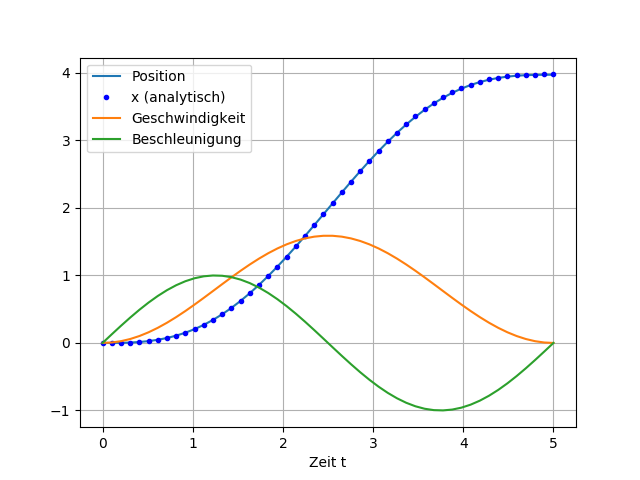

In [2]:
# System in Zustandsraumdarstellung

A = [[0., 1.],
     [0., 0.]]

B = [[0.], [1.]]

C = np.eye(2)

D = [[0.], [0.]]

system = lti(A, B, C, D)

T = 5
alpha = 1
t = np.linspace(0, T)
u = alpha * np.sin(2* np.pi * t / T)
tout, y, x = lsim(system, u, t)

x_analytisch = alpha * ((t*T)/(2*np.pi) - (T**2)/(4*np.pi**2) * np.sin(2* np.pi * t / T))

plt.plot(t, y[:,0], label="Position")
plt.plot(t, x_analytisch, 'bo', markersize=3, label="x (analytisch)")
plt.plot(t, y[:,1], label="Geschwindigkeit")
plt.plot(t, u, label="Beschleunigung")
plt.xlabel("Zeit t")
plt.legend()
plt.grid()
plt.show()

Der unbekanten Parameter $\alpha$ parametrisieren Eingang $u(\alpha,t,T) = \alpha \cdot \sin \left( \frac{2 \pi t}{T} \right)$. Mit den Anfangeswerten für $t_0 = 0$: $x(t_0) = 0$ und $\dot{x}(t_0) = 0$ ergibt sich nach zweifacher Integration für die Position: 
$$x(t) = \alpha \left[ \frac{T}{2 \pi} t - \frac{T^2}{4 \pi^2} \sin \left( \frac{2 \pi t}{T} \right) \right]$$
Gesucht ist die Funktion $F(T, x_T) \rightarrow \alpha$, welche den für einen vorgegeben Zielpunkt $x_T$ und Übergangsdauer $T$ benötigten Parameter $\alpha$ liefert. In analytischer Form kann sie in einfacher Weise aus der Gleichung für die Position bestimmt werden:  
$$\alpha = F(T, x_T) = \frac{2 \pi x_T}{T^2}$$

<IPython.core.display.Javascript object>


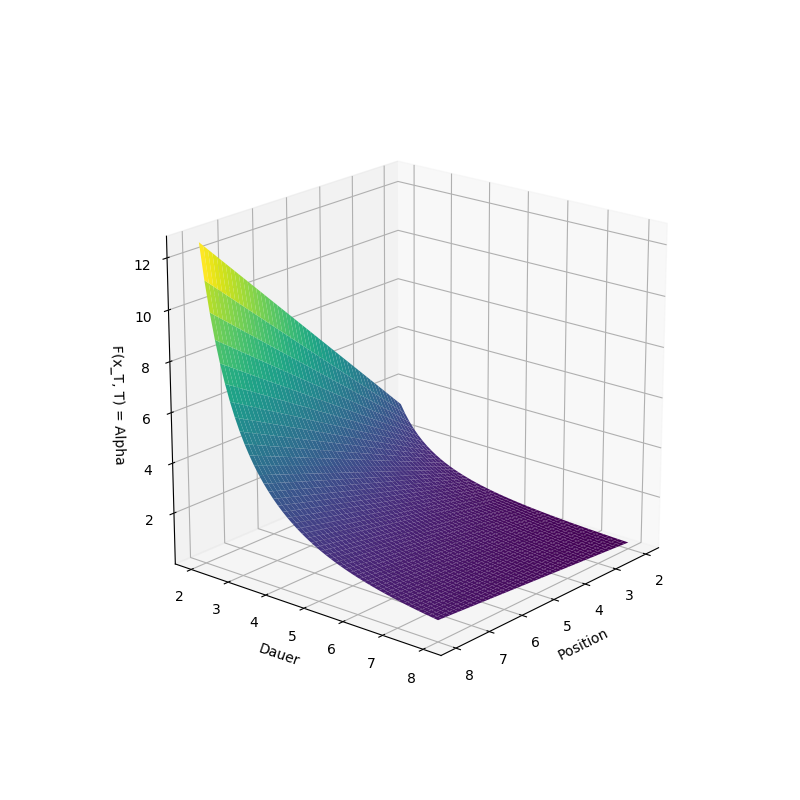

In [3]:
def F(x_T, T):
    return(2 * np.pi * x_T) / T**2

k = 50

T = np.linspace(2, 8, k)
x_T = np.linspace(2, 8, k)

x_T, T = np.meshgrid(x_T, T)

Z = F(x_T, T)

fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d')
ax.view_init(20, 40)
ax.plot_surface(x_T, T, Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.set_xlabel('Position')
ax.set_ylabel('Dauer')
ax.set_zlabel('F(x_T, T) = Alpha')
plt.show()

__Statische Funktionsapproximation mittels LLMs__:

In [4]:
from lolimot import LolimotRegressor

# TRAINING

k = 80 # Grid führt zu k*k Samples
x_T, T = np.meshgrid(np.linspace(2, 8, k), np.linspace(2, 8, k))

y = np.reshape(F(x_T, T), (k*k, ))
X = np.vstack((x_T.flatten(), T.flatten())).T

lolimot = LolimotRegressor(smoothing='proportional',
                           model_complexity=32,
                           x_range=[(2, 8), (2, 8)])


lolimot.fit(X=X, y=y)

HBox(children=(IntProgress(value=0, max=128), HTML(value='')))

LolimotRegressor(model_complexity=128, p=0.3333333333333333, sigma=0.4,
         smoothing='proportional', x_range=[(2, 5.0), (2, 8)])

In [5]:
# PREDICTION

k = 200 # Grid führt zu k*k Samples
x_T, T = np.meshgrid(np.linspace(2, 8, k), np.linspace(2, 8, k))

y = np.reshape(F(x_T, T), (k*k, ))
X_test = np.vstack((x_T.flatten(), T.flatten())).T

Z = np.reshape(lolimot.predict(X_test), (k,k))

In [6]:
# ZUGEHÖRIGKEITSFUNKTIONEN

if lolimot.M_ <= 6:
    plt.figure()
    plt.title("Zugehörigkeitsfunktionen")
    plt.grid(True)
    ax = plt.axes(projection='3d')
    for idx, column in enumerate(lolimot.A):
        Z_ = np.reshape(column, (k,k))
        ax.plot_surface(x_T, T, Z_, rstride=1, cstride=1, cmap='viridis', edgecolor='none')


    plt.show()

<IPython.core.display.Javascript object>


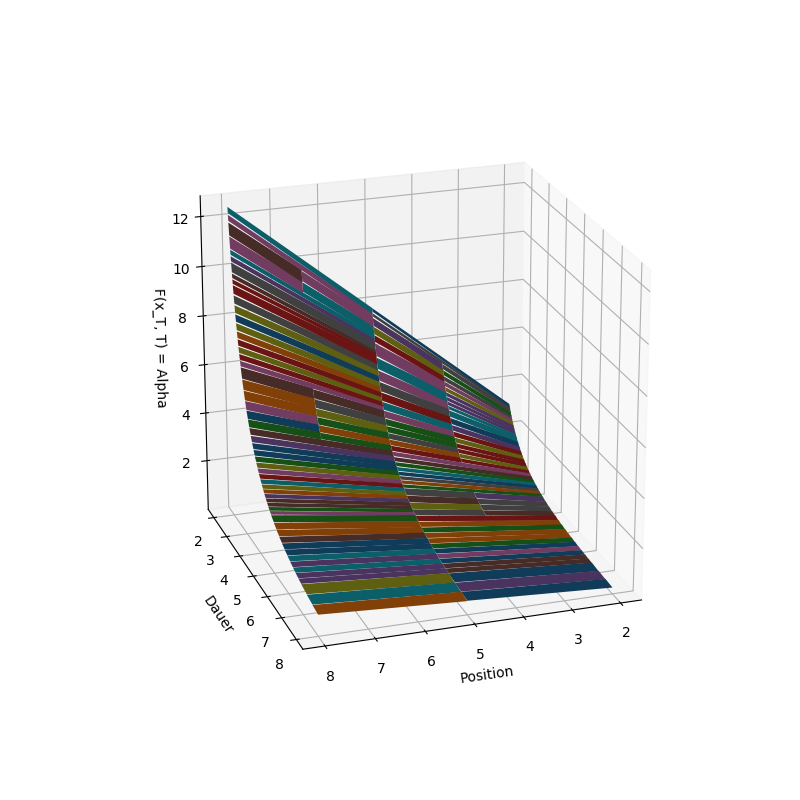

/home/philipp/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [7]:
# TEILMODELLE

plt.figure(figsize=(8, 8))
plt.title("Teilmodelle")
plt.grid(True)
ax = plt.axes(projection='3d')
ax.view_init(20, 40)
ax.set_xlabel('Position')
ax.set_ylabel('Dauer')
ax.set_zlabel('F(x_T, T) = Alpha')
for idx, (x, y, c) in enumerate(lolimot.local_model_gen()):
    ax.plot_surface(*x, y, rstride=1, cstride=1)#, cmap='viridis', edgecolor='none')

<IPython.core.display.Javascript object>


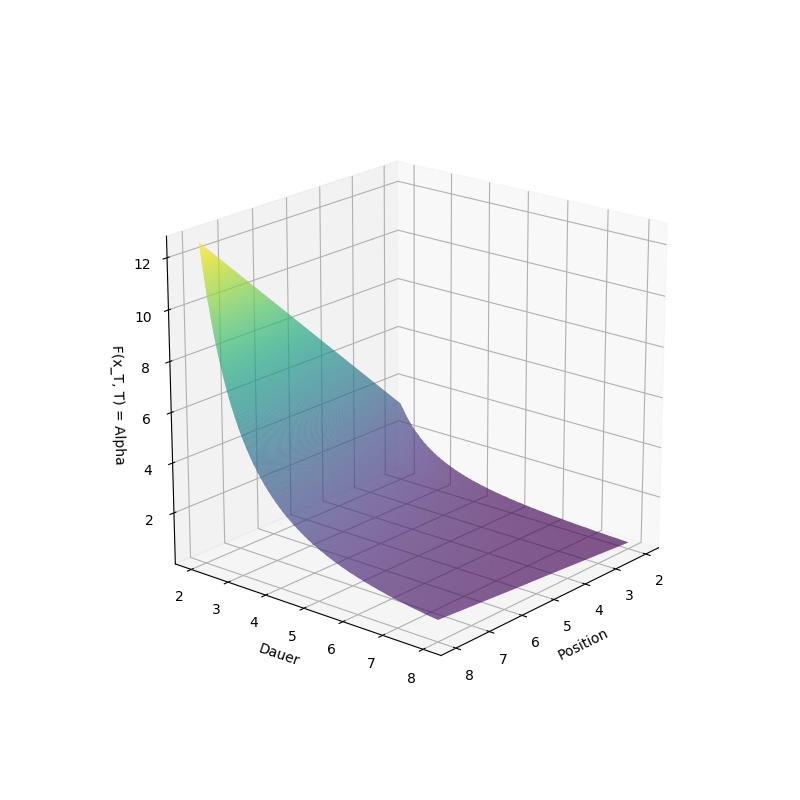

In [8]:
# ERGEBNIS

fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d')
ax.view_init(20, 40)
ax.plot_surface(x_T, T, Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.set_xlabel('Position')
ax.set_ylabel('Dauer')
ax.set_zlabel('F(x_T, T) = Alpha')
plt.show()

<IPython.core.display.Javascript object>


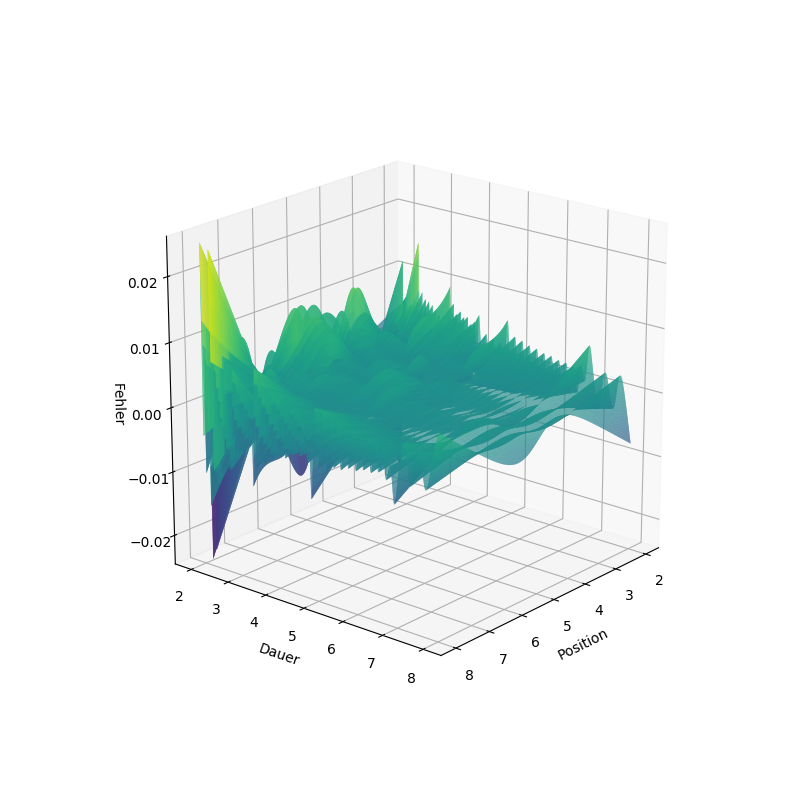

In [9]:
# FEHLER

fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d')
ax.view_init(20, 40)
ax.plot_surface(x_T, T, Z-F(x_T, T), rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.set_xlabel('Position')
ax.set_ylabel('Dauer')
ax.set_zlabel('Fehler')
plt.show()